In [28]:
from datetime import timedelta, datetime

import pandas as pd

from src.stock_history.klines import KLinesStockHistory
from src.training.extractors.config import DataExtractionConfig
from src.training.extractors.klines_preparer import KLinesStockHistoryExtractor
from src.training.extractors.vision_binance_extractor import VisionBinanceExtractor
from src.training.target.short_position import ShortPositionFabric, ShortPositionParameters


def daterange(start_date, end_date):
    current = start_date
    while current < end_date:
        yield current
        current = current + timedelta(days=1)


### Download

In [3]:
csv_filenames = []

binance_downloader = VisionBinanceExtractor(
    currency=DataExtractionConfig.CURRENCY,
    timestamp=DataExtractionConfig.TIMESTAMP,
)

for curr_date in daterange(DataExtractionConfig.START_DATE, DataExtractionConfig.END_DATE):
    print(curr_date)
    binance_downloader.download_file(report_date=curr_date)
    csv_filenames.append(
        binance_downloader.unzip_file(report_date=curr_date),
    )


2025-07-01 00:00:00
2025-07-02 00:00:00
2025-07-03 00:00:00
2025-07-04 00:00:00
2025-07-05 00:00:00
2025-07-06 00:00:00
2025-07-07 00:00:00
2025-07-08 00:00:00
2025-07-09 00:00:00


In [4]:
csv_filenames

['data\\spot\\daily\\klines\\BTCUSDT\\1m\\BTCUSDT-1m-2025-07-01.csv',
 'data\\spot\\daily\\klines\\BTCUSDT\\1m\\BTCUSDT-1m-2025-07-02.csv',
 'data\\spot\\daily\\klines\\BTCUSDT\\1m\\BTCUSDT-1m-2025-07-03.csv',
 'data\\spot\\daily\\klines\\BTCUSDT\\1m\\BTCUSDT-1m-2025-07-04.csv',
 'data\\spot\\daily\\klines\\BTCUSDT\\1m\\BTCUSDT-1m-2025-07-05.csv',
 'data\\spot\\daily\\klines\\BTCUSDT\\1m\\BTCUSDT-1m-2025-07-06.csv',
 'data\\spot\\daily\\klines\\BTCUSDT\\1m\\BTCUSDT-1m-2025-07-07.csv',
 'data\\spot\\daily\\klines\\BTCUSDT\\1m\\BTCUSDT-1m-2025-07-08.csv',
 'data\\spot\\daily\\klines\\BTCUSDT\\1m\\BTCUSDT-1m-2025-07-09.csv']

### CreatePosition

#### Read data


In [2]:
history_extractor = KLinesStockHistoryExtractor(
    currency=DataExtractionConfig.CURRENCY,
    timestamp=DataExtractionConfig.TIMESTAMP,
)

klines_window = KLinesStockHistory()

for curr_date in daterange(DataExtractionConfig.START_DATE_READ, DataExtractionConfig.END_DATE_READ):
    print(curr_date)
    klines_window = klines_window.concat(
        stock_history=history_extractor.extract_history(curr_date),
    )


2025-07-02 00:00:00
2025-07-03 00:00:00
2025-07-04 00:00:00
2025-07-05 00:00:00
2025-07-06 00:00:00
2025-07-07 00:00:00
2025-07-08 00:00:00


#### Short Position

In [82]:
parameters = ShortPositionParameters(
    leverage = 5,
    quote_qty = 200,  # QUOTE CURRENCY (USDT)
    max_duration = timedelta(days=1, hours=0),
    stop_loss = 10,  # QUOTE CURRENCY (USDT)
    take_profit = 20,  # QUOTE CURRENCY (USDT)
)

short_position_fabric = ShortPositionFabric(
    short_position_parameters=parameters,
    klines_history=klines_window,
)

short_position = short_position_fabric.open(
    start_datetime=datetime(year=2025, month=7, day=3, hour=1, minute=0),
)

short_position.estimate()
print(short_position.get_result())


ShortPositionResult(pnl=np.float64(-10.48307618652082), duration=Timedelta('0 days 08:41:59.999999'))


In [71]:
short_position._entry_price

np.float64(108906.01)

In [26]:
window = klines_window.get_window()

In [85]:
window

,open_time,open,high,low,close,volume,close_time,quote_volume,num_trades,taker_base_volume,taker_quote_volume,ignore,close_datetime
153,1751855580000000,109360.48,109379.92,109349.99,109379.91,5.10507,1751855639999999,5.582985e+05,1251,1.47493,161300.440315,0,2025-07-07 02:33:59.999999
713,1751543580000000,109678.23,109678.24,109664.28,109664.28,2.11100,1751543639999999,2.315286e+05,568,0.29441,32290.354132,0,2025-07-03 11:53:59.999999
222,1751514120000000,108806.23,108809.75,108783.82,108809.74,6.48126,1751514179999999,7.051571e+05,1422,3.24754,353335.375505,0,2025-07-03 03:42:59.999999
1308,1751838480000000,109168.15,109195.70,109057.81,109057.82,10.76835,1751838539999999,1.174975e+06,6707,4.10842,448233.886126,0,2025-07-06 21:48:59.999999
878,1751985480000000,108763.44,108813.40,108763.44,108805.78,5.35664,1751985539999999,5.828068e+05,1668,3.95678,430491.536121,0,2025-07-08 14:38:59.999999


In [84]:
window[
    window['close_datetime'].ge(pd.Timestamp(year=2025, month=7, day=3, hour=1))
    & window['close_datetime'].le(pd.Timestamp(year=2025, month=7, day=3, hour=2))
]

,open_time,open,high,low,close,volume,close_time,quote_volume,num_trades,taker_base_volume,taker_quote_volume,ignore,close_datetime
60,1751504400000000,108915.00,108915.00,108906.00,108906.01,2.41869,1751504459999999,2.634245e+05,563,0.87341,9.512462e+04,0,2025-07-03 01:00:59.999999
61,1751504460000000,108906.00,108906.01,108871.74,108871.75,1.81350,1751504519999999,1.974791e+05,1145,0.87959,9.578243e+04,0,2025-07-03 01:01:59.999999
62,1751504520000000,108871.75,108871.75,108825.99,108826.00,1.82945,1751504579999999,1.991457e+05,1185,0.36132,3.933239e+04,0,2025-07-03 01:02:59.999999
63,1751504580000000,108826.00,108849.76,108807.43,108849.76,25.53911,1751504639999999,2.779320e+06,2056,3.09619,3.369429e+05,0,2025-07-03 01:03:59.999999
64,1751504640000000,108849.75,108885.70,108849.75,108885.69,6.17840,1751504699999999,6.725752e+05,871,6.05534,6.591800e+05,0,2025-07-03 01:04:59.999999
65,1751504700000000,108885.70,108939.46,108867.49,108894.45,9.46382,1751504759999999,1.030657e+06,3005,4.80185,5.228729e+05,0,2025-07-03 01:05:59.999999
66,1751504760000000,108894.45,108894.45,108880.00,108880.01,2.71017,1751504819999999,2.951099e+05,525,0.35179,3.830471e+04,0,2025-07-03 01:06:59.999999
67,1751504820000000,108880.01,108880.01,108868.13,108870.00,2.51838,1751504879999999,2.741937e+05,889,0.65362,7.116377e+04,0,2025-07-03 01:07:59.999999
68,1751504880000000,108870.00,108942.89,108870.00,108942.88,5.96832,1751504939999999,6.498707e+05,1453,5.26632,5.734230e+05,0,2025-07-03 01:08:59.999999
69,1751504940000000,108942.88,108970.07,108922.29,108922.30,7.11088,1751504999999999,7.748034e+05,1752,2.81348,3.065452e+05,0,2025-07-03 01:09:59.999999


In [55]:
(108758.56 - 108879.53) * 200 / 108758.56 * 50

-11.122802655717505

In [42]:
200 / 108899.99 * 2

0.0036730949194761172

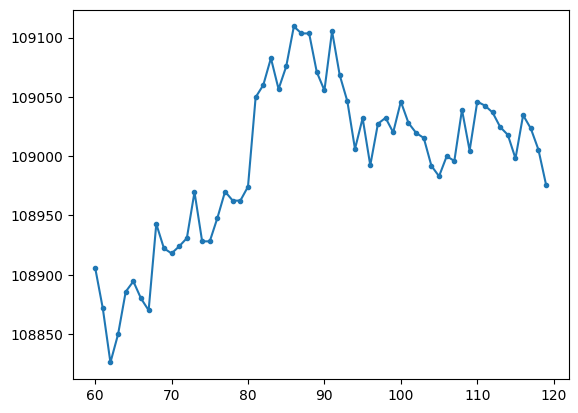

In [70]:
ax = window[
    window['close_datetime'].ge(pd.Timestamp(year=2025, month=7, day=3, hour=1))
    & window['close_datetime'].le(pd.Timestamp(year=2025, month=7, day=3, hour=2))
]['close'].plot(
    marker='.',
)

# ax.axvline(22, color='r')
# ax.axvline(29, color='r')


In [17]:
short_position.estimate()

In [18]:
short_position.get_result()

ShortPositionResult(pnl=np.float64(10.948577681229398), duration=Timedelta('0 days 00:21:59.999999'))

In [4]:
window = klines_window.get_window()

In [7]:
subwindow = window.iloc[1000:]

In [22]:
leverage = 2
duration = timedelta(hours=2)
stop_loss = 10
take_profit = 10
entry_price = 109533.73
quote_qty = 200
qty = quote_qty / entry_price * leverage

# P&L = (Entry Price - Current Price) × Кол-во актива

subwindow.iloc[100]

open_time                       1751480400000000
open                                   109182.51
high                                   109201.44
low                                    109166.04
close                                  109166.05
volume                                   6.92249
close_time                      1751480459999999
quote_volume                       755830.918632
num_trades                                  1712
taker_base_volume                        0.98266
taker_quote_volume                  107295.79197
ignore                                         0
close_datetime        2025-07-02 18:20:59.999999
Name: 1100, dtype: object

In [23]:
(entry_price - 109166.05) * qty

1.3427096840397676

In [12]:
qty

0.0018259215677216508